<center>
    <img src="https://gitlab.com/ibm/skills-network/courses/placeholder101/-/raw/master/labs/module%201/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing\_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


***


## Import Libraries and Define Auxiliary Functions


We will import the following libraries for the lab


In [1]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
%matplotlib inline

This function is to plot the confusion matrix.


In [17]:
# function for plotting the confussion matrix
def plot_confusion_matrix(y,y_predict,label):
    "this function plots the confusion matrix"
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    title = 'Confusion Matrix '+ label
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    nameFig = 'ConfussionMaterix_Multivariate_RidgeRegression_'+label+'.png'
    plt.savefig(nameFig)
    plt.show()
    #plt.close()

## Load the dataframe


Load the data


In [3]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# data = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_2.csv')

data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [4]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')

# If you were unable to complete the previous lab correctly you can uncomment and load this csv

# X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/dataset_part_3.csv')

X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [5]:
y = data.Class.to_numpy()
print(y)

[0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [6]:
# students get this 
transform = preprocessing.StandardScaler()

In [7]:
# lets normalize eqch feature simulataneouly
from sklearn.preprocessing import StandardScaler
# lets create the object that will normalize our features in X
SCALE = StandardScaler()

SCALE.fit(X.loc[:,X.columns])
x_scaled = SCALE.transform(X.loc[:,X.columns])

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [9]:
    x_train, x_test, y_train, y_test= train_test_split( X, y, test_size=0.2, random_state=2)

we can see we only have 18 test samples.


In [11]:
y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [12]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

============== Test Sice: 1/ 5
--------- Cross Validation cv:  3

 GridSearchCV
GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             return_train_score=True)


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.


 Estimalor List
LogisticRegression()

 lets find the best values for the free parameters
LogisticRegression(C=1)
tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.861111111111111
tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy with training data : 0.861111111111111
accuracy : 0.861111111111111

 Lets calculate the R^2 for the training data set
0.9305555555555556

 Lets calculate the R^2 for the testing data set
0.7777777777777778
jaccard_score:  0.7142857142857143
f1_score:  0.7592592592592591
log_loss score:  7.675461331631307


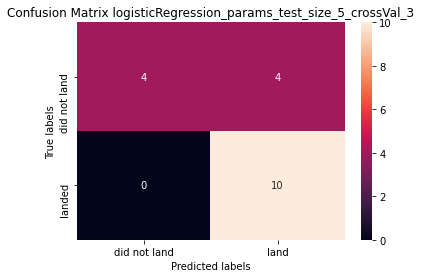

************************** GRID SEARCH RESULTS
Logistic Regression Best score
[0.861111111111111, 0.9305555555555556, 0.7777777777777778, 0.7142857142857143, 0.7592592592592591, 7.675461331631307, 5, 3]
Logistic Regression Best parameters
LogisticRegression(C=1)


In [18]:
best_scheme_lr = np.zeros(8) # R^2 sore, K values, cv value
best_params_lr = []


#for test_size_n in range(3,11):
for test_size_n in range(5,6):
    print("============== Test Sice: 1/",test_size_n)
    x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split( X, y, test_size=float(1/test_size_n), random_state=4)
    #
    #for cvn in range(3,11):
    for cvn in range(3,4):
        print("--------- Cross Validation cv: ",cvn)

        logreg_cv = GridSearchCV(lr,parameters,cv = cvn,return_train_score=True) # logreg_cv ???
        print("\n GridSearchCV")
        print(logreg_cv)
        #
        # lets fit the model to the training targets
        logreg_cv.fit(x_train_lr,y_train_lr)
        # lets fit the model to the training targets
        logreg_cv.fit(x_train_lr,y_train_lr)
        print("\n Estimalor List")
        print(logreg_cv.estimator)
        #lets find the best values for the free parameters
        print("\n lets find the best values for the free parameters")
        print(logreg_cv.best_estimator_)
        #
        # lets get the mean sccore in the cross-validation data
        scores = logreg_cv.cv_results_ #The resulting score of the different free parameters are stored in this dictionary
        ##print("\n lets get the mean sccore in the cross-validation data")
        ##print(scores['mean_test_score'])
        #
        # lets print out the score for the different free parameter values
        #print(scores)
        ##print("\n lets print out the score for the different free parameter values")
        ##for param, mean_val, mean_train in zip( scores['params'],scores['mean_test_score'],scores['mean_train_score'] ):
        ##    print(param,"R^2 on test data", mean_val,"R^2 on train data", mean_train)
        #
        print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
        print("accuracy :",logreg_cv.best_score_)

        print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
        print("accuracy with training data :",logreg_cv.best_score_)
        accuracy_lr = logreg_cv.best_score_
        print("accuracy :",accuracy_lr)
        #
        #
        yhat_lr_params =logreg_cv.predict(x_test_lr)
        yhat_train_lr_params = logreg_cv.predict(x_train_lr)
        #
        print("\n Lets calculate the R^2 for the training data set")
        trainingScore_lr = logreg_cv.score(x_train_lr,y_train_lr)
        print(trainingScore_lr)
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_lr = logreg_cv.score(x_test_lr,y_test_lr)
        print(testScore_lr)
        #
        #from sklearn.metrics import jaccard_score
        jaccardVal_lr = jaccard_score(y_test_lr, yhat_lr_params)
        print("jaccard_score: ",jaccardVal_lr)
        #from sklearn.metrics import f1_score
        f1Val_lr = f1_score(y_test_lr, yhat_lr_params, average='weighted')
        print("f1_score: ",f1Val_lr)
        #from sklearn.metrics import log_loss
        loglossVal_lr = log_loss(y_test_lr, yhat_lr_params)
        print("log_loss score: ",loglossVal_lr)
        #
        #if (best_scheme_lr[4]<accuracy_lr):
        if (best_scheme_lr[4]<f1Val_lr):
            best_scheme_lr = [accuracy_lr,trainingScore_lr,testScore_lr,jaccardVal_lr,f1Val_lr,loglossVal_lr,test_size_n,cvn]
            best_params_lr = logreg_cv.best_estimator_
################################################## Plotting confussin matrix
        label = "logisticRegression_params_test_size_"+str(test_size_n)+"_crossVal_"+str(cvn)
        plot_confusion_matrix(y_test_lr,yhat_lr_params,label)
        #
print("************************** GRID SEARCH RESULTS")
print("Logistic Regression Best score")
print(best_scheme_lr)
print("Logistic Regression Best parameters")
print(best_params_lr)

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [19]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.861111111111111


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [21]:
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_lr = logreg_cv.score(x_test_lr,y_test_lr)
        print(testScore_lr)


 Lets calculate the R^2 for the testing data set
0.7777777777777778


Lets look at the confusion matrix:


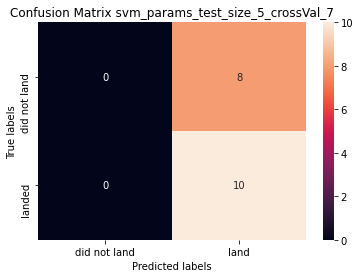

In [42]:
yhat=svmreg_cv.predict(x_test)
plot_confusion_matrix(y_test_lr,yhat,label)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [28]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()



 ******************** SUPPORT VECTOR MACHINE *******************
============== Test Sice: 1/ 5
--------- Cross Validation cv:  7

 GridSearchCV
GridSearchCV(cv=7, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('rbf', 'sigmoid')},
             return_train_score=True)

 Estimalor List
SVC()

 lets find the best values for the free parameters
SVC(C=0.001, gamma=0.001)

 lets print out the score for the different free parameter values
tuned hpyerparameters :(best parameters)  {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
accuracy with training data : 0.6948051948051949
accuracy : 0.6948051948051949

 Lets calculate the R^2 for the training data set
0.6944444444444444

 Lets calculate the R^2 for the testing data set
0.5555555555

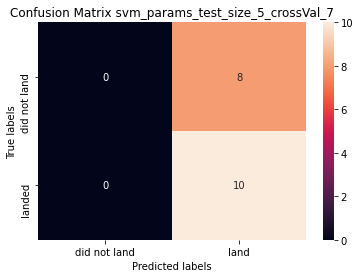

************************** GRID SEARCH RESULTS
SUPPORT VECTOR MACHINE Best score
[0.6948051948051949, 0.6944444444444444, 0.5555555555555556, 0.5555555555555556, 0.39682539682539686, 5, 7]
SUPPORT VECTOR MACHINE Best parameters
SVC(C=0.001, gamma=0.001)


In [35]:
print("\n\n ******************** SUPPORT VECTOR MACHINE *******************")
from sklearn.svm import SVC
parameters_svm = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
#
best_scheme_svm = np.zeros(7) # R^2 sore, K values, cv value
best_params_svm = []


#for test_size_n in range(3,11):
for test_size_n in range(5,6):
    print("============== Test Sice: 1/",test_size_n)
    x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split( X, y, test_size=float(1/test_size_n), random_state=4)
    #
    #for cvn in range(3,11):
    for cvn in range(7,8):
        print("--------- Cross Validation cv: ",cvn)
        svmreg_cv = GridSearchCV(svm,{'kernel':('rbf', 'sigmoid'),'C': np.logspace(-3, 3, 5),'gamma':np.logspace(-3, 3, 5)},cv = cvn,return_train_score=True)
        print("\n GridSearchCV")
        print(svmreg_cv)
        # lets fit the model to the training targets
        svmreg_cv.fit(x_train_svm,y_train_svm)
        print("\n Estimalor List")
        print(svmreg_cv.estimator)
        #lets find the best values for the free parameters
        print("\n lets find the best values for the free parameters")
        print(svmreg_cv.best_estimator_)
        #
        #
        # lets get the mean sccore in the cross-validation data
        scores = svmreg_cv.cv_results_ #The resulting score of the different free parameters are stored in this dictionary
        ##print("\n lets get the mean sccore in the cross-validation data")
        ##print(scores['mean_test_score'])
        #
        ### lets print out the score for the different free parameter values
        ###print(scores)
        print("\n lets print out the score for the different free parameter values")
        ##for param, mean_val, mean_train in zip( scores['params'],scores['mean_test_score'],scores['mean_train_score'] ):
        ##    print(param,"R^2 on test data", mean_val,"R^2 on train data", mean_train)
        #
        print("tuned hpyerparameters :(best parameters) ",svmreg_cv.best_params_)
        print("accuracy with training data :",svmreg_cv.best_score_)
        accuracy_svm = svmreg_cv.best_score_
        print("accuracy :",accuracy_svm)
        #
        #
        yhat_svm_params =svmreg_cv.predict(x_test_svm)
        yhat_train_svm_params = svmreg_cv.predict(x_train_svm)
        #
        print("\n Lets calculate the R^2 for the training data set")
        trainingScore_svm = svmreg_cv.score(x_train_svm,y_train_svm)
        print(trainingScore_svm)
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_svm = svmreg_cv.score(x_test_svm,y_test_svm)
        print(testScore_svm)
        #
        #from sklearn.metrics import jaccard_score
        #print("jaccard_score: ",jaccard_score(y_test, yhat_svm_params,pos_label=2))
        #from sklearn.metrics import jaccard_score
        jaccardVal_svm = jaccard_score(y_test_svm, yhat_svm_params)
        print("jaccard_score: ",jaccardVal_svm)
        #from sklearn.metrics import f1_score
        f1Val_svm = f1_score(y_test_svm, yhat_svm_params, average='weighted')
        print("f1_score: ",f1Val_svm)
        #from sklearn.metrics import log_loss
        ##print("log_loss score: ",log_loss(y_test, yhat_svm_params))
        #
        #if (best_scheme_svm[4]<accuracy_svm):
        if (best_scheme_svm[4]<f1Val_svm):
            best_scheme_svm = [accuracy_svm,trainingScore_svm,testScore_svm,jaccardVal_svm,f1Val_svm,test_size_n,cvn]
            best_params_svm = svmreg_cv.best_estimator_
################################################## Plotting confussin matrix
        label = "svm_params_test_size_"+str(test_size_n)+"_crossVal_"+str(cvn)
        plot_confusion_matrix(y_test_svm,yhat_svm_params,label)

print("************************** GRID SEARCH RESULTS")
print("SUPPORT VECTOR MACHINE Best score")
print(best_scheme_svm)
print("SUPPORT VECTOR MACHINE Best parameters")
print(best_params_svm)

In [36]:
print("tuned hpyerparameters :(best parameters) ",svmreg_cv.best_params_)
print("accuracy :",svmreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
accuracy : 0.6948051948051949


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [37]:
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_svm = svmreg_cv.score(x_test_svm,y_test_svm)
        print(testScore_svm)


 Lets calculate the R^2 for the testing data set
0.5555555555555556


We can plot the confusion matrix


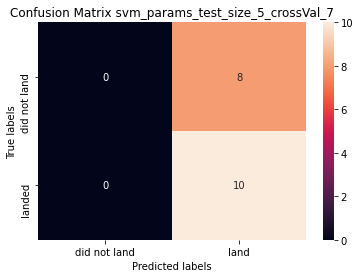

In [41]:
yhat=svmreg_cv.predict(x_test)
plot_confusion_matrix(y_test_svm,yhat,label)

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [ ]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()



 ******************** DECISION TREE *******************
============== Test Sice: 1/ 5
--------- Cross Validation cv:  3

 Estimalor List
DecisionTreeClassifier()

 lets find the best values for the free parameters
DecisionTreeClassifier(max_depth=2, max_features='auto', min_samples_leaf=2)
tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.9027777777777778

 Lets calculate the R^2 for the training data set
0.8888888888888888

 Lets calculate the R^2 for the testing data set
0.7777777777777778
jaccard_score:  0.6923076923076923
f1_score:  0.7720057720057719


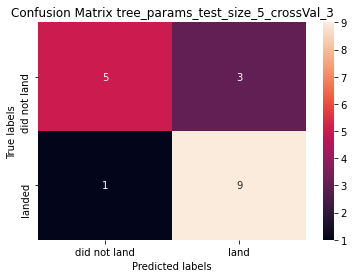

************************** GRID SEARCH RESULTS
DECISION TREE Best score
[0.9027777777777778, 0.8888888888888888, 0.7777777777777778, 0.6923076923076923, 0.7720057720057719, 5, 3]
DECISION TREE Best parameters
DecisionTreeClassifier(max_depth=2, max_features='auto', min_samples_leaf=2)


In [44]:
print("\n\n ******************** DECISION TREE *******************")


from sklearn.tree import DecisionTreeClassifier

parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 14]}
#
tree = DecisionTreeClassifier()
#
best_scheme_tree = np.zeros(7) # R^2 sore, K values, cv value
best_params_tree = []

#for test_size_n in range(3,11):
for test_size_n in range(5,6):
    print("============== Test Sice: 1/",test_size_n)
    x_train_tree, x_test_tree, y_train_tree, y_test_tree = train_test_split( X, y, test_size=float(1/test_size_n), random_state=4)
    #
    #for cvn in range(3,11):
    for cvn in range(3,4):
        print("--------- Cross Validation cv: ",cvn)
        treereg_cv = GridSearchCV(tree,parameters,cv = cvn,return_train_score=True)
        treereg_cv.fit(x_train_tree,y_train_tree)
        #
        print("\n Estimalor List")
        print(treereg_cv.estimator)
        #lets find the best values for the free parameters
        print("\n lets find the best values for the free parameters")
        print(treereg_cv.best_estimator_)
        #
        # lets get the mean sccore in the cross-validation data
        scores = treereg_cv.cv_results_ #The resulting score of the different free parameters are stored in this dictionary
        ##print("\n lets get the mean sccore in the cross-validation data")
        ##print(scores['mean_test_score'])
        #
        ### lets print out the score for the different free parameter values
        ###print(scores)
        ##print("\n lets print out the score for the different free parameter values")
        ##for param, mean_val, mean_train in zip( scores['params'],scores['mean_test_score'],scores['mean_train_score'] ):
        ##    print(param,"R^2 on test data", mean_val,"R^2 on train data", mean_train)
        #
        #
        print("tuned hpyerparameters :(best parameters) ",treereg_cv.best_params_)
        accuracy_tree = treereg_cv.best_score_
        print("accuracy :",accuracy_tree)
        #
        #
        yhat_tree_params =treereg_cv.predict(x_test_tree)
        yhat_train_tree_params = treereg_cv.predict(x_train_tree)
        #
        print("\n Lets calculate the R^2 for the training data set")
        trainingScore_tree = treereg_cv.score(x_train_tree,y_train_tree)
        print(trainingScore_tree)
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_tree = treereg_cv.score(x_test_tree,y_test_tree)
        print(testScore_tree)
        #
        #from sklearn.metrics import jaccard_score
        #print("jaccard_score: ",jaccard_score(y_test, yhat_tree_params,pos_label=2))
        jaccardVal_tree = jaccard_score(y_test_tree, yhat_tree_params)
        print("jaccard_score: ",jaccardVal_tree)
        #from sklearn.metrics import f1_score
        f1Val_tree = f1_score(y_test_tree, yhat_tree_params, average='weighted')
        print("f1_score: ",f1Val_tree)
        #from sklearn.metrics import log_loss
        ##print("log_loss score: ",log_loss(y_test, yhat_tree_params))
        #
        #if (best_scheme_tree[4]<accuracy_tree):
        if (best_scheme_tree[4]<f1Val_tree):
            best_scheme_tree = [accuracy_tree,trainingScore_tree,testScore_tree,jaccardVal_tree,f1Val_tree,test_size_n,cvn]
            best_params_tree = treereg_cv.best_estimator_
################################################## Plotting confussin matrix
        label = "tree_params_test_size_"+str(test_size_n)+"_crossVal_"+str(cvn)
        plot_confusion_matrix(y_test_tree,yhat_tree_params,label)


print("************************** GRID SEARCH RESULTS")
print("DECISION TREE Best score")
print(best_scheme_tree)
print("DECISION TREE Best parameters")
print(best_params_tree)

In [46]:
print("tuned hpyerparameters :(best parameters) ",treereg_cv.best_params_)
print("accuracy :",treereg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.9027777777777778


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [51]:
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_tree = treereg_cv.score(x_test_tree,y_test_tree)
        print(testScore_tree)


 Lets calculate the R^2 for the testing data set
0.7777777777777778


We can plot the confusion matrix


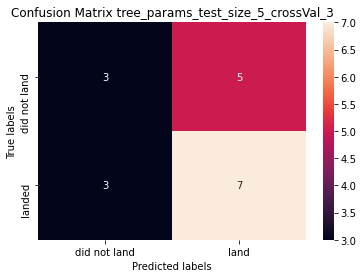

In [52]:
yhat = treereg_cv.predict(x_test)
plot_confusion_matrix(y_test_tree,yhat,label)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [53]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()



 ******************** K-neighbours *******************
============== Test Sice: 1/ 5
--------- Cross Validation cv:  7

 GridSearchCV
GridSearchCV(cv=7, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 14],
                         'p': [1, 2]},
             return_train_score=True)

 Estimalor List
KNeighborsClassifier()

 lets find the best values for the free parameters
KNeighborsClassifier(n_neighbors=14, p=1)
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 14, 'p': 1}
accuracy : 0.6935064935064935
tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 14, 'p': 1}
accuracy with training data : 0.6935064935064935
accuracy : 0.6935064935064935

 Lets calculate the R^2 for the training data set
0.6944444444444444

 Lets calculate the R^2 for the testing data set
0.5
jaccard_score:  0.4375
f1_scor

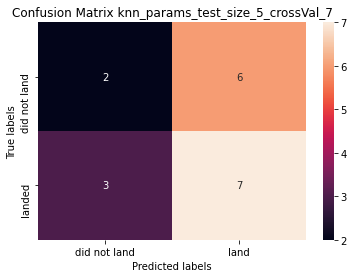

************************** GRID SEARCH RESULTS
K nearest neighbours Best score
[0.6935064935064935, 0.6944444444444444, 0.5, 0.4375, 0.47491638795986624, 5, 7]
K nearest neighbours Best parameters
KNeighborsClassifier(n_neighbors=14, p=1)


In [55]:
print("\n\n ******************** K-neighbours *******************")

from sklearn.neighbors import KNeighborsClassifier
    
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 14],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}
KNN = KNeighborsClassifier()
#
best_scheme_knn = np.zeros(7) # R^2 sore, K values, cv value
best_params_knn = []

#for test_size_n in range(3,11):
for test_size_n in range(5,6):
    print("============== Test Sice: 1/",test_size_n)
    x_train_knn, x_test_knn, y_train_knn, y_test_knn = train_test_split( X, y, test_size=float(1/test_size_n), random_state=4)
    #
    #for cvn in range(3,11):
    for cvn in range(7,8):
        print("--------- Cross Validation cv: ",cvn)

        knn_reg_cv = GridSearchCV(KNN,parameters,cv = cvn,return_train_score=True) # knn_reg_cv ???
        print("\n GridSearchCV")
        print(knn_reg_cv)
        #
        # lets fit the model to the training targets
        knn_reg_cv.fit(x_train_knn,y_train_knn)
        # lets fit the model to the training targets
        knn_reg_cv.fit(x_train_knn,y_train_knn)
        print("\n Estimalor List")
        print(knn_reg_cv.estimator)
        #lets find the best values for the free parameters
        print("\n lets find the best values for the free parameters")
        print(knn_reg_cv.best_estimator_)
        #
        # lets get the mean sccore in the cross-validation data
        scores = knn_reg_cv.cv_results_ #The resulting score of the different free parameters are stored in this dictionary
        ##print("\n lets get the mean sccore in the cross-validation data")
        ##print(scores['mean_test_score'])
        #
        # lets print out the score for the different free parameter values
        #print(scores)
        ##print("\n lets print out the score for the different free parameter values")
        ##for param, mean_val, mean_train in zip( scores['params'],scores['mean_test_score'],scores['mean_train_score'] ):
        ##    print(param,"R^2 on test data", mean_val,"R^2 on train data", mean_train)
        #
        print("tuned hpyerparameters :(best parameters) ",knn_reg_cv.best_params_)
        print("accuracy :",knn_reg_cv.best_score_)

        print("tuned hpyerparameters :(best parameters) ",knn_reg_cv.best_params_)
        print("accuracy with training data :",knn_reg_cv.best_score_)
        accuracy_knn = knn_reg_cv.best_score_
        print("accuracy :",accuracy_knn)
        #
        #
        yhat_knn_params =knn_reg_cv.predict(x_test_knn)
        yhat_train_knn_params = knn_reg_cv.predict(x_train_knn)
        #
        print("\n Lets calculate the R^2 for the training data set")
        trainingScore_knn = knn_reg_cv.score(x_train_knn,y_train_knn)
        print(trainingScore_knn)
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_knn = knn_reg_cv.score(x_test_knn,y_test_knn)
        print(testScore_knn)
        #
        #from sklearn.metrics import jaccard_score
        #print("jaccard_score: ",jaccard_score(y_test, yhat_knn_params,pos_label=2))
        jaccardVal_knn = jaccard_score(y_test_knn, yhat_knn_params)
        print("jaccard_score: ",jaccardVal_knn)
        #from sklearn.metrics import f1_score
        f1Val_knn = f1_score(y_test_knn, yhat_knn_params, average='weighted')
        print("f1_score: ",f1Val_knn)
        #from sklearn.metrics import log_loss
        ##print("log_loss score: ",log_loss(y_test, yhat_knn_params))
        #
        #if (best_scheme_knn[4]<accuracy_knn):
        if (best_scheme_knn[4]<f1Val_knn):
            best_scheme_knn = [accuracy_knn,trainingScore_knn,testScore_knn,jaccardVal_knn,f1Val_knn,test_size_n,cvn]
            best_params_knn = knn_reg_cv.best_estimator_
################################################## Plotting updatedd confussin matrix
            label = "knn_params_test_size_"+str(test_size_n)+"_crossVal_"+str(cvn)
            plot_confusion_matrix(y_test_knn,yhat_knn_params,label)

print("************************** GRID SEARCH RESULTS")
print("K nearest neighbours Best score")
print(best_scheme_knn)
print("K nearest neighbours Best parameters")
print(best_params_knn)


In [56]:
print("tuned hpyerparameters :(best parameters) ",knn_reg_cv.best_params_)
print("accuracy :",knn_reg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 14, 'p': 1}
accuracy : 0.6935064935064935


## TASK  11


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [57]:
        print("\n Lets calculate the R^2 for the testing data set")
        testScore_knn = knn_reg_cv.score(x_test_knn,y_test_knn)
        print(testScore_knn)


 Lets calculate the R^2 for the testing data set
0.5


We can plot the confusion matrix


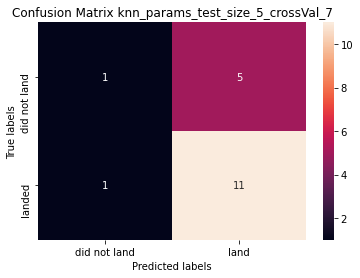

In [60]:
yhat = knn_reg_cv.predict(x_test)
plot_confusion_matrix(y_test,yhat,label)

## TASK  12


Find the method performs best:


The best performing algorithms are Decision Trees and Logistic Regression

## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2021-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By    | Change Description      |
| ----------------- | ------- | ------------- | ----------------------- |
| 2021-08-31        | 1.1     | Lakshmi Holla | Modified markdown       |
| 2020-09-20        | 1.0     | Joseph        | Modified Multiple Areas |


Copyright © 2020 IBM Corporation. All rights reserved.
